In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import time

In [ ]:
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Load the data

In [3]:
cars = glob.glob("./vehicles/*/*.png")
non_cars = glob.glob("./non-vehicles/*/*.png")

t=time.time()
X=[]
for car in cars:
    image = cv2.imread(car)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X.append(image)
for non_car in non_cars:
    image = cv2.imread(non_car)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X.append(image)
X = np.array(X)
print(len(X))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to load the data...')

17760
5.18 Seconds to load the data...


In [4]:
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))])
print(Y)
print(len(Y))

[ 1.  1.  1. ...,  0.  0.  0.]
17760


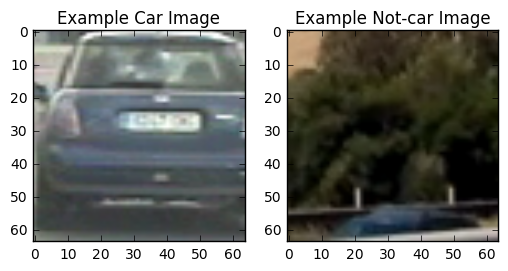

In [5]:
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(X[0])
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(X[-1])
plt.title('Example Not-car Image')

# Training and validation set split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (15984, 64, 64, 3)
15984 train samples
1776 test samples


# Train with Keras a convnet classifier model

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


def convnet(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1")) # This was Dense(128)
    model.add(Dropout(0.5))
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh")) # This was Dense(1)
    if filename:
        model.load_weights(filename)        
    return model

model = convnet()
model.add(Flatten()) # (None, 1, 1, 1) -> (None, 1)
model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 64, 64, 10)    280         lambda_1[0][0]                   
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 64, 64, 10)    910         conv1[0][0]                      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 8, 8, 10)      0           conv2[0][0]                      
___________________________________________________________________________________________

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

PATIENCE = 3

#filepath="model.epoch{epoch:02d}-valloss{val_loss:.4f}.h5"
#checkpoint = ModelCheckpoint(filepath, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1)

t=time.time()
history_object = model.fit(X_train, Y_train, batch_size=128, nb_epoch=30, verbose=1, validation_data=(X_test, Y_test), callbacks = [early_stopping])
t2=time.time()
print(round(t2-t, 2), 'Seconds to train the model...')

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
model.save_weights("convnet.h5")


Train on 15984 samples, validate on 1776 samples
Epoch 1/30
15984/15984 [==============================] - 3s - loss: 0.1065 - acc: 0.8587 - val_loss: 0.0449 - val_acc: 0.9527
Epoch 2/30
15984/15984 [==============================] - 2s - loss: 0.0396 - acc: 0.9518 - val_loss: 0.0243 - val_acc: 0.9741
Epoch 3/30
15984/15984 [==============================] - 2s - loss: 0.0268 - acc: 0.9677 - val_loss: 0.0179 - val_acc: 0.9792
Epoch 4/30
15984/15984 [==============================] - 2s - loss: 0.0208 - acc: 0.9740 - val_loss: 0.0107 - val_acc: 0.9899
Epoch 5/30
15984/15984 [==============================] - 2s - loss: 0.0165 - acc: 0.9790 - val_loss: 0.0086 - val_acc: 0.9893
Epoch 6/30
15984/15984 [==============================] - 2s - loss: 0.0152 - acc: 0.9804 - val_loss: 0.0091 - val_acc: 0.9910
Epoch 7/30
15984/15984 [==============================] - 2s - loss: 0.0112 - acc: 0.9861 - val_loss: 0.0060 - val_acc: 0.9955
Epoch 8/30
15984/15984 [==============================] - 2s -

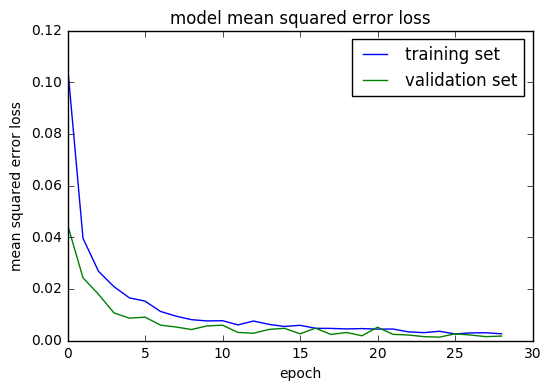

In [9]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('history.png')
plt.show()

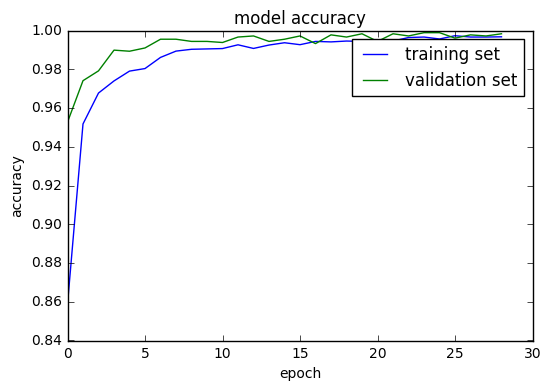

In [10]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('history.png')
plt.show()

In [11]:
ls

convnet.h5     non-vehicles.zip   README.md       vehicles.zip
examples/      output_images/     test_images/    writeup_template.md
history.png    P5.ipynb           test_video.mp4
non-vehicles/  project_video.mp4  vehicles/


# Create a heatmap

In [350]:
THRESHOLD = 0.99

In [351]:
heatmodel = convnet(input_shape=(None, None, 3), filename="convnet.h5")

In [352]:
heatmodel.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_16 (Lambda)               (None, None, None, 3) 0           lambda_input_16[0][0]            
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, None, None, 10 280         lambda_16[0][0]                  
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, None, None, 10 910         conv1[0][0]                      
____________________________________________________________________________________________________
maxpooling2d_16 (MaxPooling2D)   (None, None, None, 10 0           conv2[0][0]                      
___________________________________________________________________________________________

In [420]:
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

heatmap = heatmodel.predict(image.reshape(1, image.shape[0], image.shape[1], image.shape[2]))
print(image.shape)
print(heatmap.shape)

(720, 1280, 3)
(1, 83, 153, 1)


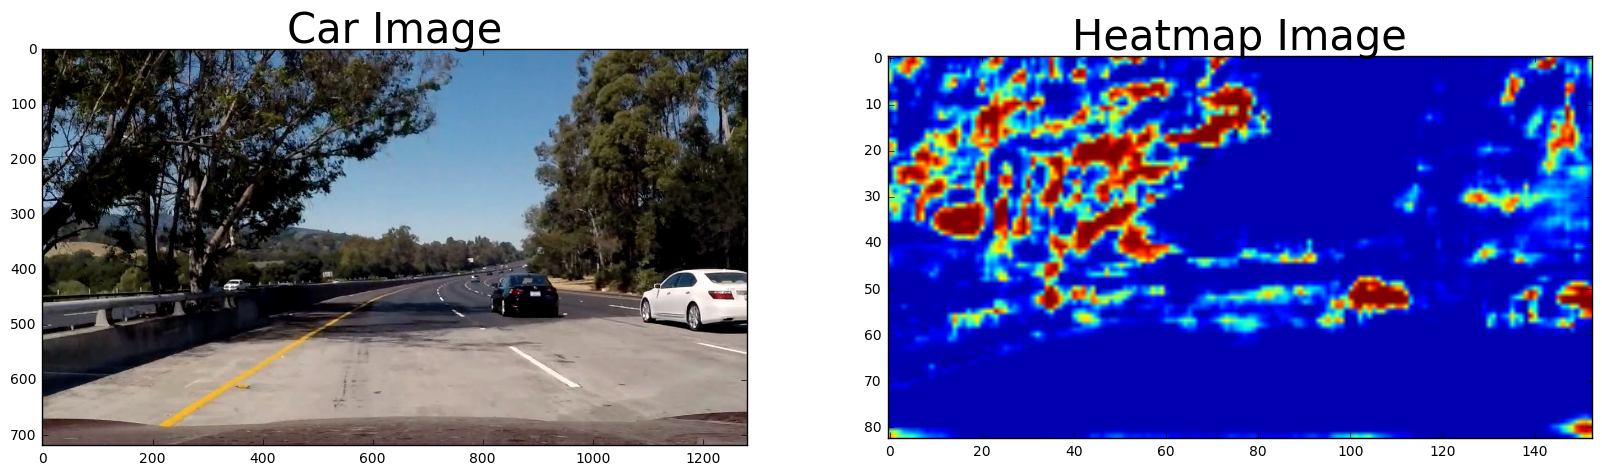

In [421]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Car Image', fontsize=30)
ax2.imshow(heatmap[0,:,:,0])
ax2.set_title('Heatmap Image', fontsize=30)

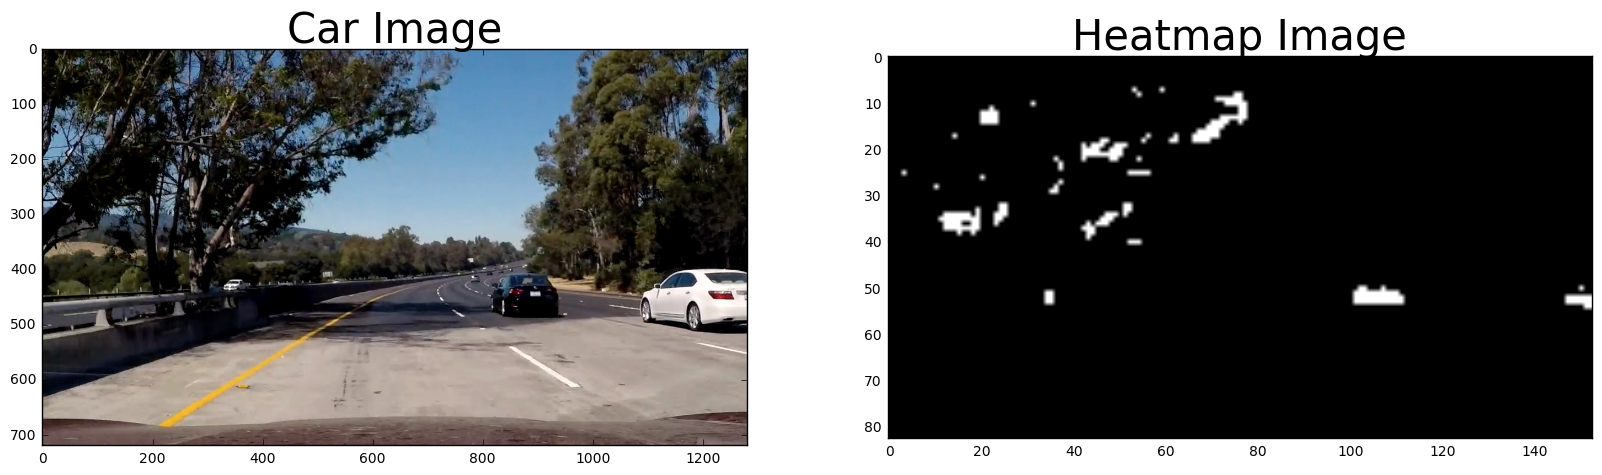

In [422]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Car Image', fontsize=30)
ax2.imshow(heatmap[0,:,:,0]>THRESHOLD, cmap="gray")
ax2.set_title('Heatmap Image', fontsize=30)

In [423]:
xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
x = (xx[heatmap[0,:,:,0]>THRESHOLD])
y = (yy[heatmap[0,:,:,0]>THRESHOLD])

In [435]:
print(xx.shape)
print(yy.shape)

(83, 153)
(83, 153)


In [396]:
print(len(x))
print(len(y))

81
81


424 56
472 56
432 64
600 64
608 64
568 72
576 72
584 72
592 72
600 72
608 72
248 80
584 80
592 80
600 80
608 80
616 80
176 88
608 88
616 88
160 96
168 96
176 96
184 96
608 96
616 96
160 104
168 104
176 104
184 104
576 104
584 104
592 104
600 104
608 104
616 104
160 112
168 112
176 112
184 112
560 112
568 112
576 112
584 112
608 112
552 120
560 120
568 120
576 120
536 128
544 128
552 128
560 128
568 128
112 136
448 136
496 136
528 136
536 136
544 136
552 136
560 136
568 136
368 144
376 144
440 144
488 144
496 144
528 144
536 144
544 144
552 144
336 152
352 152
360 152
368 152
392 152
400 152
408 152
336 160
344 160
352 160
360 160
384 160
392 160
400 160
336 168
344 168
352 168
360 168
368 168
376 168
384 168
392 168
400 168
288 176
336 176
384 176
392 176
432 176
296 184
296 192
24 200
416 200
424 200
432 200
440 200
448 200
160 208
296 216
80 224
288 224
280 232
288 232
192 256
200 256
408 256
416 256
152 264
192 264
200 264
408 264
416 264
96 272
104 272
112 272
120 272
128 272
136 2

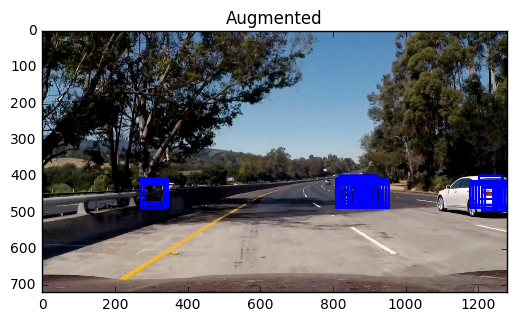

In [424]:
rect = []
for i,j in zip(x,y):
        #print(i*8, j*8)
        mx = i*8
        my = j*8
        print(mx, my)
        if my >= 400 and my <= 620:
            cv2.rectangle(image, (mx, my), (mx+64,my+64), (0,0,255), 5)
            rect.append((mx, my, 64, 64))

plt.title("Augmented")    
plt.imshow(image)
plt.show()

In [398]:
print(rect)

[(816, 400, 64, 64), (824, 400, 64, 64), (832, 400, 64, 64), (840, 400, 64, 64), (848, 400, 64, 64), (816, 408, 64, 64), (824, 408, 64, 64), (832, 408, 64, 64), (840, 408, 64, 64), (848, 408, 64, 64), (856, 408, 64, 64), (864, 408, 64, 64), (872, 408, 64, 64), (808, 416, 64, 64), (816, 416, 64, 64), (824, 416, 64, 64), (832, 416, 64, 64), (840, 416, 64, 64), (848, 416, 64, 64), (856, 416, 64, 64), (864, 416, 64, 64), (872, 416, 64, 64), (880, 416, 64, 64), (888, 416, 64, 64), (1056, 416, 64, 64), (1064, 416, 64, 64), (1088, 416, 64, 64), (1096, 416, 64, 64), (1104, 416, 64, 64), (1136, 416, 64, 64), (1144, 416, 64, 64), (1152, 416, 64, 64), (1176, 416, 64, 64), (1184, 416, 64, 64), (808, 424, 64, 64), (816, 424, 64, 64), (824, 424, 64, 64), (832, 424, 64, 64), (840, 424, 64, 64), (848, 424, 64, 64), (856, 424, 64, 64), (864, 424, 64, 64), (872, 424, 64, 64), (880, 424, 64, 64), (888, 424, 64, 64), (896, 424, 64, 64), (1064, 424, 64, 64), (1088, 424, 64, 64), (1096, 424, 64, 64), (1104,

In [431]:
thresh=1
#rect1 , w1 = cv2.groupRectangles(list(rect), thresh)
#rect1 , w1 = cv2.groupRectangles(list(rect), thresh, 0.1)
rect1 , w1 = cv2.groupRectangles(np.array(rect).tolist(), 6, 0.4)
#np.array(mouth).tolist()
print(rect1)

[[ 845  415   64   64]
 [1198  420   64   64]]


In [432]:
print(w1)

[[35]
 [15]]


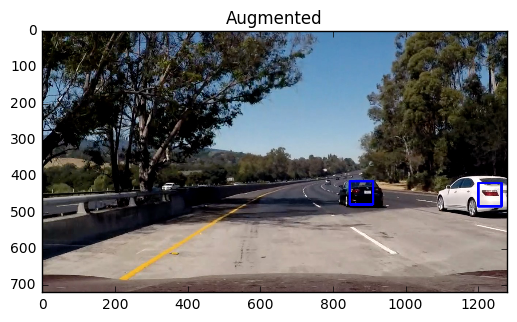

In [433]:
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for (mx,my,mw,mh) in rect1:
        #print(i*8, j*8)
        cv2.rectangle(image, (mx, my), (mx+mw, my+mh), (0,0,255), 5)

plt.title("Augmented")    
plt.imshow(image)
plt.show()

In [362]:
print(rect)

[]


In [ ]:
rect1 , w1 = cv2.groupRectangles(np.array(rect).tolist(), 1, 1)


In [316]:
np.array(rect)[:,0]

array([ 824,  832, 1144,  816,  824,  832,  840,  848,  856,  864,  872,
        880,  808,  816,  824,  832,  840,  848,  856,  864,  872,  880,
        888, 1112, 1120, 1128, 1136, 1144, 1152, 1160, 1168, 1176,  816,
        824,  832,  840,  848,  856,  864,  872,  880,  888, 1120, 1128,
       1136, 1144, 1152, 1160, 1168, 1176,  816,  832,  840,  848,  856,
        864, 1152, 1160, 1168, 1176,  816,  832,  840,  848,  856,  864,
       1168,  832,  840])

In [322]:
rect2 = non_max_suppression_fast(np.array(rect), 0)
print(len(rect))
print(len(rect2))

69
69
